In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in the data and merge climbing record with weather 

In [15]:
climbing_statistics = pd.read_csv('data/climbing_statistics.csv')
climbing_statistics['Date'] = pd.to_datetime(climbing_statistics['Date'], format='%m/%d/%Y')
weather = pd.read_csv('data/Rainier_Weather.csv')
weather['Date'] = pd.to_datetime(weather['Date'], format='%m/%d/%Y')

climbs_df = pd.merge(climbing_statistics, weather, how='left', on='Date')
print(climbs_df.head())

        Date                   Route  Attempted  Succeeded  \
0 2015-11-27  Disappointment Cleaver          2          0   
1 2015-11-21  Disappointment Cleaver          3          0   
2 2015-10-15  Disappointment Cleaver          2          0   
3 2015-10-13           Little Tahoma          8          0   
4 2015-10-09  Disappointment Cleaver          2          0   

   Success Percentage  Battery Voltage AVG  Temperature AVG  \
0                 0.0            13.643750        26.321667   
1                 0.0            13.749583        31.300000   
2                 0.0            13.461250        46.447917   
3                 0.0            13.532083        40.979583   
4                 0.0            13.216250        38.260417   

   Relative Humidity AVG  Wind Speed Daily AVG  Wind Direction AVG  \
0              19.715000             27.839583           68.004167   
1              21.690708              2.245833          117.549667   
2              27.211250             1

## Check for missing values

In [16]:
climbs_df.isnull().agg(['count', 'sum', 'mean'])

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
count,4077.0,4077.0,4077.0,4077.0,4077.0,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000
sum,0.0,0.0,0.0,0.0,0.0,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000
mean,0.0,0.0,0.0,0.0,0.0,0.535197,0.535197,0.535197,0.535197,0.535197,0.535197


### Remove all observations with missing weather data since it's random and har to impute 

In [17]:
climbs_df = climbs_df.dropna()
climbs_df.shape[0]

1895

# When is peak season for climbing? 

Weekday    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Month                                                                    
January      18.0      0.0        2.0      21.0    21.0      36.0     8.0
February     16.0      0.0        3.0       0.0    15.0      31.0    19.0
March        54.0      4.0        6.0      11.0    12.0      29.0    41.0
April        59.0      5.0       13.0      19.0    37.0      76.0    64.0
May         264.0    126.0      193.0     192.0   435.0     684.0   234.0
June        820.0    624.0      501.0     700.0   986.0    1159.0   816.0
July        838.0    789.0      673.0    1060.0  1358.0     936.0   825.0
August      629.0    508.0      430.0     433.0   757.0     873.0   680.0
September   280.0    158.0      181.0     152.0   345.0     375.0   277.0
October       1.0      8.0        0.0       2.0     6.0      15.0     0.0
November      0.0      0.0        0.0       0.0     2.0       3.0     2.0
December      0.0      0.0        0.0 

Text(0.5, 1, 'Success rate')

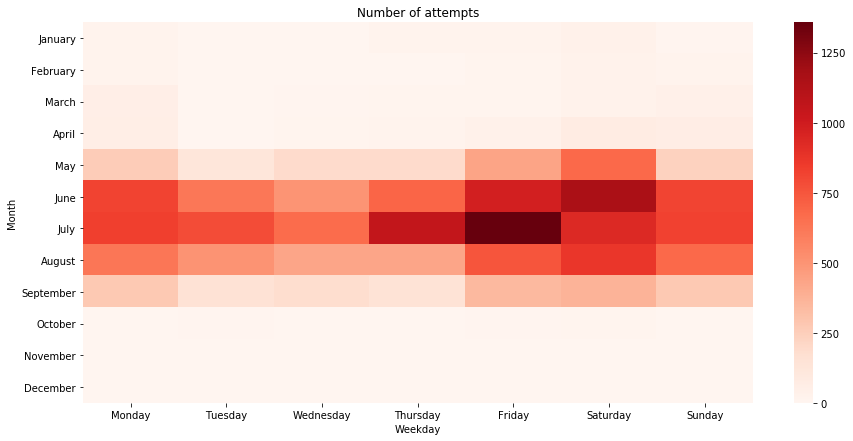

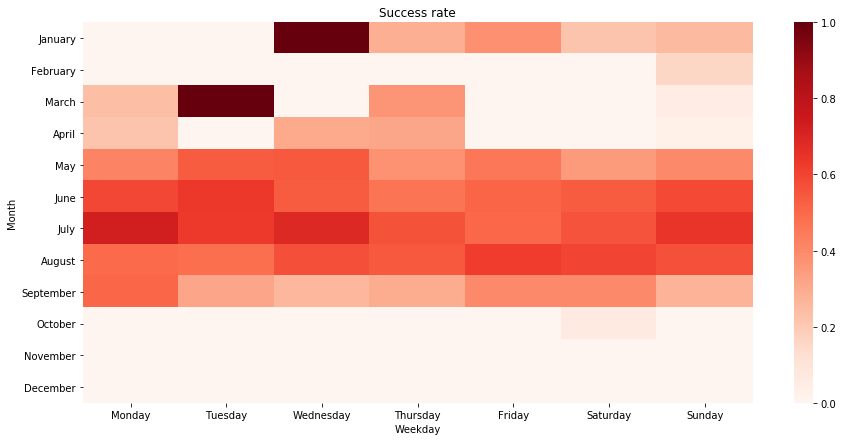

In [50]:
# use full climbing dataset since we do not need weather to answer this question
peak_season = climbing_statistics[['Date', 'Attempted', 'Succeeded']]
peak_season = peak_season.groupby('Date').sum()
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
peak_season['Month'] = peak_season.index.month
peak_season['Weekday'] = peak_season.index.weekday
peak_season = peak_season.groupby(['Month', 'Weekday']).sum().reset_index()
peak_season['Success_rate'] = peak_season['Succeeded'] / peak_season['Attempted']
attempts = peak_season.pivot(columns='Weekday', index='Month', values='Attempted').fillna(0)
attempts = attempts.rename(index=months, columns=weekdays)
print(attempts)
plt.figure(figsize=[15,7])
sns.heatmap(attempts, cmap='Reds')
plt.title('Number of attempts')

success_rate = peak_season.pivot(columns='Weekday', index='Month', values='Success_rate').fillna(0)
success_rate = success_rate.rename(index=months, columns=weekdays)
print(success_rate)
plt.figure(figsize=[15,7])
sns.heatmap(success_rate, cmap='Reds')
plt.title('Success rate')

In [52]:
climbs_df.groupby('Attempted').count()

,Date,Route,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
Attempted,,,,,,,,,,
1,55,55,55,55,55,55,55,55,55,55
2,554,554,554,554,554,554,554,554,554,554
3,342,342,342,342,342,342,342,342,342,342
4,213,213,213,213,213,213,213,213,213,213
5,86,86,86,86,86,86,86,86,86,86
6,83,83,83,83,83,83,83,83,83,83
7,25,25,25,25,25,25,25,25,25,25
8,47,47,47,47,47,47,47,47,47,47
9,30,30,30,30,30,30,30,30,30,30
